In [1]:
import os
import cv2
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torchvision
from torch.utils.data import DataLoader,Dataset
from torch import nn
from torch import optim

device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [2]:
class CNNBlock(nn.Module):
    def __init__(self,in_channels,out_channels,stride):
        super().__init__()
        self.conv=nn.Sequential(
            nn.Conv2d(in_channels,
                      out_channels,
                      4,
                      stride,
                      1,
                      bias=False,
                      padding_mode="reflect"
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )
    
    def forward(self,x):
        return self.conv(x)

class Discriminator(nn.Module):
    def __init__(self,in_channels=3,features=[64,128,256,512]):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(
                in_channels * 2,
                features[0],
                kernel_size=4,
                stride=2,
                padding=1,
                padding_mode="reflect",
            ),
            nn.LeakyReLU(0.2),
        )
        
        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(
                CNNBlock(in_channels,feature,stride=1 if feature == features[-1] else 2),
            )
            in_channels=feature
            
        layers.append(
            nn.Conv2d(
                in_channels, 1, kernel_size=4, stride=1, padding=1, padding_mode="reflect"
            )
        )
        
        self.model = nn.Sequential(*layers)
        #basically unpack the layers from the list
        
    def forward(self, x, y):
        x = torch.cat([x, y], dim=1)
        x = self.initial(x)
        x = self.model(x)
        return x

In [3]:
#test
x=torch.randn(32,3,256,256)
y=torch.randn(32,3,256,256)
model=Discriminator()
preds=model(x,y)
print(preds.shape)

torch.Size([32, 1, 30, 30])


In [4]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, act="relu", use_dropout=False):
        super(Block, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False, padding_mode="reflect")
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU() if act == "relu" else nn.LeakyReLU(0.2),
        )

        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)
        self.down = down

    def forward(self, x):
        x = self.conv(x)
        return self.dropout(x) if self.use_dropout else x


class Generator(nn.Module):
    def __init__(self, in_channels=3, features=4):
        super().__init__()
        self.initial_down = nn.Sequential(
            nn.Conv2d(in_channels, features, 4, 2, 1, padding_mode="reflect"),
            nn.LeakyReLU(0.2),
        )
        self.down1 = Block(features, features * 2, down=True, act="leaky", use_dropout=False)
        self.down2 = Block(
            features * 2, features * 4, down=True, act="leaky", use_dropout=False
        )
        self.down3 = Block(
            features * 4, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.down4 = Block(
            features * 8, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.down5 = Block(
            features * 8, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.down6 = Block(
            features * 8, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.bottleneck = nn.Sequential(
            nn.Conv2d(features * 8, features * 8, 4, 2, 1), nn.ReLU()
        )

        self.up1 = Block(features * 8, features * 8, down=False, act="relu", use_dropout=True)
        self.up2 = Block(
            features * 8 * 2, features * 8, down=False, act="relu", use_dropout=True
        )
        self.up3 = Block(
            features * 8 * 2, features * 8, down=False, act="relu", use_dropout=True
        )
        self.up4 = Block(
            features * 8 * 2, features * 8, down=False, act="relu", use_dropout=False
        )
        self.up5 = Block(
            features * 8 * 2, features * 4, down=False, act="relu", use_dropout=False
        )
        self.up6 = Block(
            features * 4 * 2, features * 2, down=False, act="relu", use_dropout=False
        )
        self.up7 = Block(features * 2 * 2, features, down=False, act="relu", use_dropout=False)
        self.final_up = nn.Sequential(
            nn.ConvTranspose2d(features * 2, in_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        d1 = self.initial_down(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        d7 = self.down6(d6)
        bottleneck = self.bottleneck(d7)
        up1 = self.up1(bottleneck)
        up2 = self.up2(torch.cat([up1, d7], 1))
        up3 = self.up3(torch.cat([up2, d6], 1))
        up4 = self.up4(torch.cat([up3, d5], 1))
        up5 = self.up5(torch.cat([up4, d4], 1))
        up6 = self.up6(torch.cat([up5, d3], 1))
        up7 = self.up7(torch.cat([up6, d2], 1))
        return self.final_up(torch.cat([up7, d1], 1))

In [5]:
x = torch.randn(1, 3, 256,256)
model = Generator(in_channels=3, features=64)
print(model(x).shape == x.shape)#should be true cause its generating another image

True


In [6]:
class CelebA(Dataset):
    def __init__(self,root):
        self.root=root
    
    def __len__(self):
        return len(os.listdir(self.root))
    
    def __getitem__(self,i):
        path='{:05d}'.format(i+1)+'.jpg'
        if path in os.listdir(self.root):
            image=cv2.imread(f'{self.root}/{path}')
            image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
            gray=cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
            inv=cv2.bitwise_not(gray)
            smooth=cv2.GaussianBlur(inv, (21,21),sigmaX=0, sigmaY=0)
            sketch=cv2.divide(gray, 255 - smooth, scale=255)
            sketch=cv2.cvtColor(sketch,cv2.COLOR_GRAY2RGB)
            
        return image,sketch

In [7]:
path='/kaggle/input/celebahq-resized-256x256/celeba_hq_256'
data=CelebA(path)
train_size=int(0.8 * len(data))
test_size=len(data)-train_size
train_data,test_data=torch.utils.data.random_split(data,[train_size,test_size])
trainloader=DataLoader(train_data,
                batch_size=128,
                shuffle=True,
               )
testloader=DataLoader(test_data,
                batch_size=128,
                shuffle=True,
               )
len(trainloader),len(testloader)

(188, 47)

In [8]:
dis=Discriminator().to(device)
gen=Generator().to(device)
opt_dis=optim.Adam(dis.parameters(),lr=2e-4,betas=(0.5,0.999))
opt_gen=optim.Adam(gen.parameters(),lr=2e-4,betas=(0.5,0.999))
BCE=torch.nn.BCEWithLogitsLoss()
L1_loss=torch.nn.L1Loss()
g_scaler=torch.cuda.amp.GradScaler()
d_scaler=torch.cuda.amp.GradScaler()

In [ ]:
def train(dis,gen,opt_dis,opt_gen,BCE,L1_loss,data,g_scaler,d_scaler):
    generator_loss=0
    discriminator_loss=0
    for batch,(X,y) in enumerate(bar := tqdm(data,leave=True)):
        batch+=1
        X=X.to(device,dtype=torch.float).permute(0,3,1,2)
        y=y.to(device,dtype=torch.float).permute(0,3,1,2)
        
        dis.train()
        gen.train()
        
        #train discriminator
        y_fake=gen(X)
        D_real=dis(X,y)
        D_fake=dis(X,y_fake.detach())
        D_real_loss = BCE(D_real,torch.ones_like(D_real))
        D_fake_loss = BCE(D_fake, torch.zeros_like(D_fake))
        D_loss = (D_real_loss + D_fake_loss) / 2
        discriminator_loss=discriminator_loss*(1-1/batch)+D_loss.item()/batch
            
        dis.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_dis)
        d_scaler.update()
        
        #train generator
        D_fake=dis(X,y_fake)
        G_fake_loss=BCE(D_fake, torch.ones_like(D_fake))
        L1 = L1_loss(y_fake, y) * 100
        G_loss=G_fake_loss+L1
        generator_loss=generator_loss*(1-1/batch)+G_loss.item()/batch
            
        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()
        if (batch-1) % 10 != 0:
            bar.set_description(f"Gen_loss : {generator_loss},Disc_Loss : {discriminator_loss}")

In [ ]:
def test(dis,gen,opt_dis,opt_gen,BCE,L1_loss,data):
    generator_loss_test=0
    discriminator_loss_test=0
    for batch,(X_test,y_test) in enumerate(bar := tqdm(data,leave=True)):
        batch+=1
        X_test=X_test.to(device,dtype=torch.float).permute(0,3,1,2)
        y_test=y_test.to(device,dtype=torch.float).permute(0,3,1,2)
        
        gen.eval()
        dis.eval()
        with torch.inference_mode():
            y_test_fake=gen(X_test)
            D_real_test=dis(X_test,y_test)
            D_fake_test=dis(X_test,y_test_fake.detach())
            D_real_loss_test = BCE(D_real_test,torch.ones_like(D_real_test))
            D_fake_loss_test = BCE(D_fake_test, torch.zeros_like(D_fake_test))
            D_loss_test = (D_real_loss_test + D_fake_loss_test) / 2
            discriminator_loss_test=discriminator_loss_test*(1-1/batch)+D_loss_test.item()/batch

            D_fake_test=dis(X_test,y_test_fake)
            G_fake_loss_test=BCE(D_fake_test, torch.ones_like(D_fake_test))
            L1_test = L1_loss(y_test_fake, y_test) * 100
            G_loss_test = G_fake_loss_test+L1_test
            generator_loss_test=generator_loss_test*(1-1/batch)+G_loss_test.item()/batch
            if (batch-1) % 10 != 0:
                bar.set_description(f"Gen_loss : {generator_loss_test},Disc_Loss : {discriminator_loss_test}")

In [ ]:
for epoch in range(3):
    train(dis,gen,opt_dis,opt_gen,BCE,L1_loss,trainloader,g_scaler,d_scaler)
    test(dis,gen,opt_dis,opt_gen,BCE,L1_loss,testloader)
    printf(f'finished epoch:{epoch}')

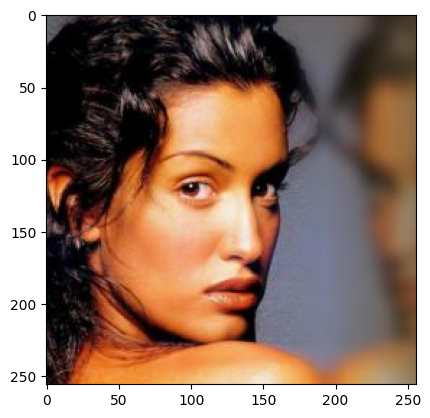

In [14]:
X,y=next(iter(trainloader))
plt.imshow(X[0])

In [15]:
X=X.to(device,dtype=torch.float).permute(0,3,1,2)
y=y.to(device,dtype=torch.float).permute(0,3,1,2)

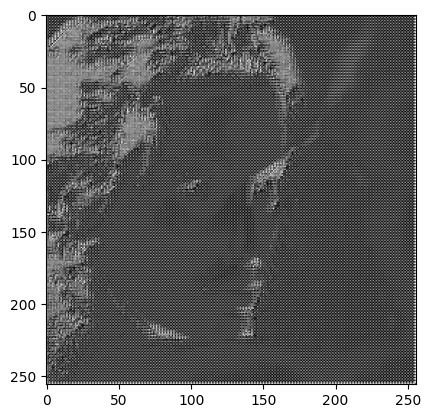

In [16]:
sk=cv2.cvtColor(gen(X)[0].detach().to("cpu").permute(1,2,0).numpy(),cv2.COLOR_RGB2GRAY)
inv=cv2.bitwise_not(sk)
plt.imshow(inv,cmap="gray")